# Inference and Validation

Quando voce tem uma rede treinada, típicamente a usa para fazer previsões, isso é chamado de `inferência`, eé um termo emprestado das estatísticas.

No entanto, redes neurais geralmente tem bom desempenho nos dados em que foram treinadas mas não são capazer de generalizar os dados que sua rede não viu antes.

Isso é chamado `overfitting`, isso acontece porque a medida que voce treina cada vez mais em seu conjunto de treinamento, sua rede começa a coletar correlações e padrões que estãi em seu conjunto de treinamento, mas não estão no conjunto de dados mais geral de todos os digitos manuscritos possiveis.

Portanto, para `testar o overfitting` medimos o desempenho da rede em dados que não estão no conjunto de treinamento. Esses dados geralmente são chamados de `conjunto de validação ou conjunto de teste`. Enquanto medimos o desempenho também tentamos `reduzir o overfitting por meio da regularização`.

<h3>Como olhar para o nosso conjunto de validação e usar dropout para reduzir o overftting?</h3>


In [9]:
# pra obter o conjunto de treinamento para seus dados dizemos que train=True.
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [10]:
#RESPOSTA DO UDACITY (DEFININDO O MODELO)

from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

O objetivo da validação é medir o desempenho do modelo em dados que não fazem parte do conjunto de treinamento.

O desempenho aqui é definido pelo desenvolvedor. Tipicamente, isso se traduz em `acurácia`, que é a **porcentagem de classes que a rede neural previu corretamente**. Outras opções incluem precisão e recall e a taxa de erro top-5. Vamos focar na acurácia aqui. Primeiro, farei uma passagem direta com um lote (batch) do conjunto de teste.

`"Dropout"` é uma técnica de regularização usada em redes neurais durante o treinamento para combater o overfitting, que é quando o modelo se ajusta demais aos dados de treinamento e não generaliza bem para novos dados. A ideia por trás do dropout é aleatoriamente desligar (ou "dropar") um certo número de neurônios em cada passagem de treinamento. Isso impede que os neurônios se especializem muito e, assim, torna a rede neural mais robusta e menos suscetível ao overfitting.

Durante o treinamento, o dropout é aplicado a cada camada da rede com uma determinada probabilidade. Isso significa que, **em cada passagem de treinamento, alguns neurônios terão seus valores de saída definidos como zero temporariamente, enquanto outros neurônios continuarão a operar normalmente.** Essa aleatoriedade na atividade dos neurônios força a rede a aprender representações mais robustas e evita que ela se ajuste demais aos dados específicos do conjunto de treinamento.

Em resumo, o dropout é uma técnica de regularização que ajuda a prevenir o overfitting ao desligar aleatoriamente neurônios durante o treinamento, incentivando a rede neural a aprender representações mais robustas e generalizáveis dos dados.

In [11]:

model = Classifier()

# Obtém um lote de dados de teste do testloader. 
# images conterá as imagens do lote e labels conterá 
# os rótulos correspondentes das classes verdadeiras.
images, labels = next(iter(testloader))

# Get the class probabilities
# Faz uma Forward pass através do modelo com as 
# imagens de teste para obter as probabilidades de 
# classe previstas para cada imagem no lote. 
# torch.exp é usado para converter as previsões de 
# log-probabilidades em probabilidades reais.
ps = torch.exp(model(images))

#  Imprime a forma (shape) do tensor ps, que contém 
# as probabilidades previstas para cada classe para 
# cada exemplo no lote. A saída esperada seria (64, 10), 
# indicando 64 exemplos com 10 probabilidades de classe para cada um.
print(ps.shape)

torch.Size([64, 10])


Com as probabilidades calculadas para cada classe, podemos obter a classe mais provável usando o método ps.topk.

Esse método retorna os $k$ maiores valores entre as probabilidades. Como estamos interessados apenas na classe mais provável, podemos usar ps.topk(1). Isso nos retorna uma tupla contendo os $k$ maiores valores e os índices correspondentes a esses valores. Se o maior valor estiver na quinta posição, receberemos de volta 4 como o índice correspondente a essa classe.

Em outras palavras, estamos obtendo o índice da classe mais provável entre todas as classes.



# Exemplo:

Vamos considerar um exemplo hipotético simplificado com um único exemplo no lote para ilustrar como determinamos a classe mais provável usando o método `topk(1).`

Suponha que temos um lote com `apenas um exemplo e 3 classes.` As saídas da rede neural após a aplicação da função de ativação softmax são:

**Probabilidades = [0.2, 0.6, 0.2]**


Aqui, cada número representa a probabilidade de pertencer a uma classe específica.

*Por exemplo, a primeira posição (índice 0) representa a probabilidade de pertencer à classe 0, a segunda posição (índice 1) representa a probabilidade de pertencer à classe 1 e assim por diante.*

Ao usar topk(1), `estamos solicitando a posição do valor mais alto. Neste caso, o valor mais alto é 0.6,` que está na posição 1 (índice 1), indicando que a classe mais provável é a classe 1.

Portanto, top_class seria [1], que é o índice da classe mais provável para o único exemplo no lote.

Espero que isso ajude a esclarecer como determinamos a classe mais provável usando topk(1).

In [12]:
# Para cada exemplo no lote, esta linha obtém a classe mais provável (com a maior probabilidade) 
# usando o método topk(1) ao longo da dimensão 1 (que representa as classes).
# top_p conterá as probabilidades mais altas, 
# enquanto top_class conterá os índices das classes mais prováveis.
top_p, top_class = ps.topk(1, dim=1)

# Look at the most likely classes for the first 10 examples
print(top_class[:10,:]) # classes mais prováveis
print(top_p[:10,:]) #  maiores probabilidades

tensor([[3],
        [7],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [3],
        [7]])
tensor([[0.1161],
        [0.1134],
        [0.1162],
        [0.1165],
        [0.1164],
        [0.1161],
        [0.1149],
        [0.1161],
        [0.1164],
        [0.1134]], grad_fn=<SliceBackward0>)


Agora podemos verificar se as classes previstas correspondem aos rótulos reais. Isso é simples de fazer, comparando top_class e labels, mas precisamos ter cuidado com as formas (shapes) dos tensores envolvidos. Aqui, top_class é um tensor 2D com formato (64, 1), enquanto labels é um tensor 1D com formato (64). Para que a comparação funcione da maneira que desejamos, top_class e labels devem ter o mesmo formato.

Se fizermos

equals = top_class == labels

equals terá formato (64, 64), experimente você mesmo. O que está acontecendo é que está comparando cada elemento da coluna de top_class com cada elemento em labels, o que retorna 64 valores booleanos Verdadeiro/Falso para cada linha.






In [13]:
# compara os índices das classes mais prováveis (top_class) com os rótulos verdadeiros (labels). 
equals = top_class == labels.view(*top_class.shape)

`labels.view(*top_class.shape):` Esta parte do código ajusta a forma do tensor labels para ser a mesma que a forma do tensor top_class. 

Isso é feito usando o método view para redimensionar o tensor labels para ter o mesmo número de elementos que o tensor top_class. 

**O uso de * desempacota a forma de top_class.shape, que é uma tupla, e passa esses valores como argumentos para view, garantindo que labels tenha a mesma forma que top_class.**

`top_class == labels.view(*top_class.shape):` Esta parte do código compara os elementos de top_class com os elementos de labels, elemento por elemento.

Se os elementos correspondentes forem **iguais, o resultado será True; caso contrário, será False.** O resultado é armazenado em um tensor booleano chamado equals, que será True para os elementos que forem iguais e False para os elementos que forem diferentes.

In [14]:
equals

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False

In [15]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up the  by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting.

In [16]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else:
        # Inicializa uma variável para armazenar a soma total das perdas (losses) no conjunto de dados de teste.
        tot_test_loss = 0
        
        # Inicializa uma variável para contar o número total de previsões corretas no conjunto de dados de teste.
        test_correct = 0
          
        # Desativa o cálculo de gradientes para acelerar o processo
        with torch.no_grad():
            
            for images, labels in testloader:
                
                # Fazemos uma passagem direta (forward pass) através do modelo 
                # com as imagens de teste para obter as probabilidades de log (log probabilities) previstas para cada classe.
                log_ps = model(images) 
                
                # Calcula a perda (loss) comparando as probabilidades de log previstas 
                # com os rótulos reais do conjunto de dados de teste.
                loss = criterion(log_ps, labels) 
                
                # Atualiza a soma total das perdas do conjunto de dados de teste.
                tot_test_loss += loss.item()
                
                # Calcula as probabilidades reais a partir das probabilidades de log.
                ps = torch.exp(log_ps)
                
                # Obtém as classes mais prováveis para cada exemplo no lote.
                top_p, top_class = ps.topk(1, dim=1)
                
                # Compara as classes mais prováveis com os rótulos reais para determinar se as previsões estão corretas ou não.
                equals = top_class == labels.view(*top_class.shape)
                
                #  Atualiza o número total de previsões corretas no conjunto de dados de teste.
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        
        # Calcula a perda média no conjunto de dados de teste dividindo a soma total
        # das perdas pelo número total de exemplos no conjunto de teste.
        train_loss = tot_train_loss / len(trainloader.dataset)
        
        # Armazena a perda média do conjunto de teste para esta época na lista test_losses.
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/30..  Training Loss: 0.517..  Test Loss: 0.454..  Test Accuracy: 0.837
Epoch: 2/30..  Training Loss: 0.391..  Test Loss: 0.400..  Test Accuracy: 0.858
Epoch: 3/30..  Training Loss: 0.361..  Test Loss: 0.379..  Test Accuracy: 0.867
Epoch: 4/30..  Training Loss: 0.338..  Test Loss: 0.375..  Test Accuracy: 0.865
Epoch: 5/30..  Training Loss: 0.318..  Test Loss: 0.378..  Test Accuracy: 0.871
Epoch: 6/30..  Training Loss: 0.304..  Test Loss: 0.363..  Test Accuracy: 0.870
Epoch: 7/30..  Training Loss: 0.295..  Test Loss: 0.362..  Test Accuracy: 0.873
Epoch: 8/30..  Training Loss: 0.283..  Test Loss: 0.402..  Test Accuracy: 0.862
Epoch: 9/30..  Training Loss: 0.272..  Test Loss: 0.373..  Test Accuracy: 0.871
Epoch: 10/30..  Training Loss: 0.270..  Test Loss: 0.361..  Test Accuracy: 0.877
Epoch: 11/30..  Training Loss: 0.258..  Test Loss: 0.384..  Test Accuracy: 0.871
Epoch: 12/30..  Training Loss: 0.255..  Test Loss: 0.352..  Test Accuracy: 0.878
Epoch: 13/30..  Training Loss: 0.247.

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

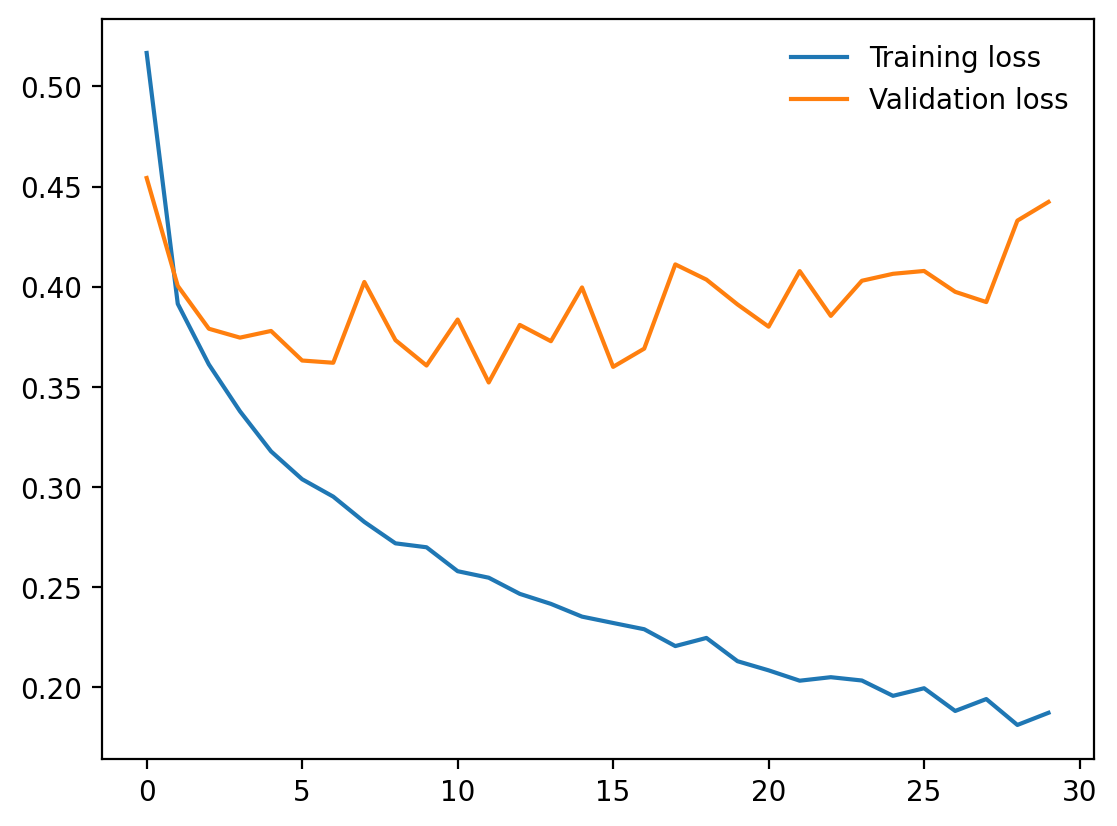

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

Exercise: Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss.

In [19]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [20]:

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.606..  Test Loss: 0.492..  Test Accuracy: 0.825
Epoch: 2/30..  Training Loss: 0.478..  Test Loss: 0.444..  Test Accuracy: 0.842
Epoch: 3/30..  Training Loss: 0.458..  Test Loss: 0.469..  Test Accuracy: 0.833
Epoch: 4/30..  Training Loss: 0.431..  Test Loss: 0.414..  Test Accuracy: 0.852
Epoch: 5/30..  Training Loss: 0.425..  Test Loss: 0.409..  Test Accuracy: 0.855
Epoch: 6/30..  Training Loss: 0.410..  Test Loss: 0.391..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.386..  Test Accuracy: 0.865
Epoch: 8/30..  Training Loss: 0.399..  Test Loss: 0.387..  Test Accuracy: 0.867
Epoch: 9/30..  Training Loss: 0.394..  Test Loss: 0.378..  Test Accuracy: 0.864
Epoch: 10/30..  Training Loss: 0.390..  Test Loss: 0.388..  Test Accuracy: 0.867
Epoch: 11/30..  Training Loss: 0.391..  Test Loss: 0.397..  Test Accuracy: 0.863
Epoch: 12/30..  Training Loss: 0.379..  Test Loss: 0.398..  Test Accuracy: 0.860
Epoch: 13/30..  Training Loss: 0.380.

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

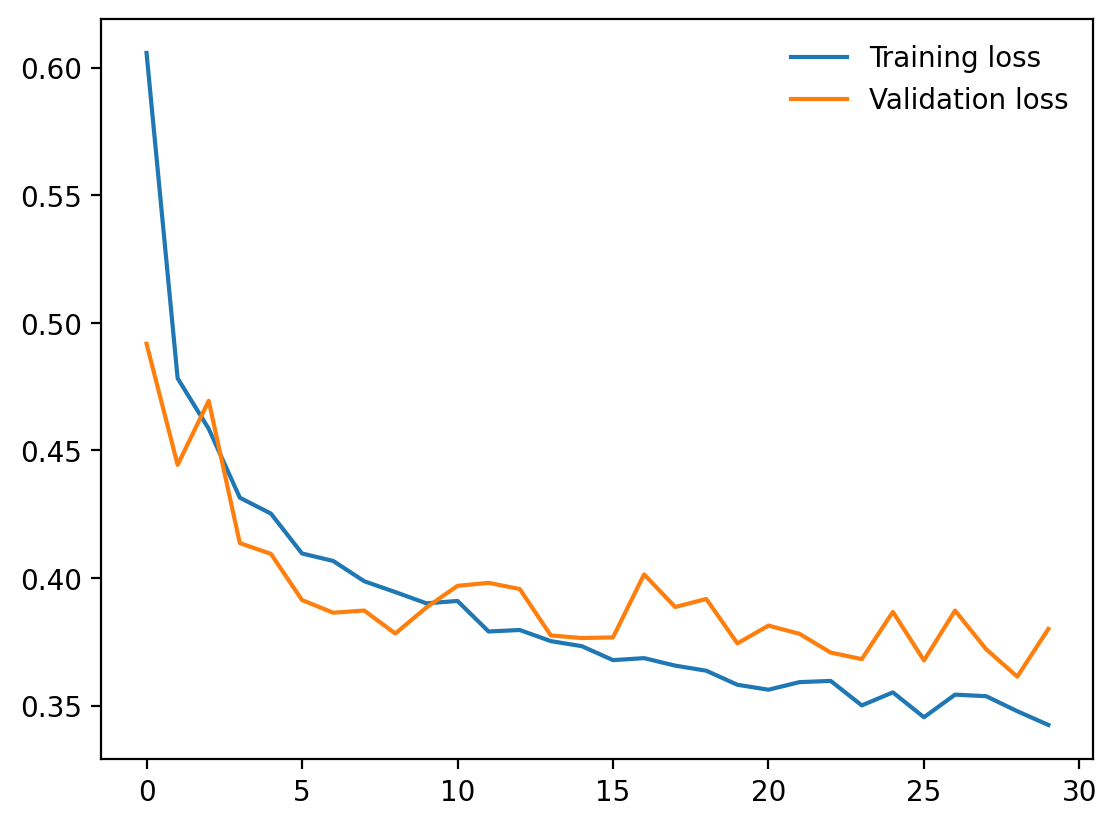

In [22]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

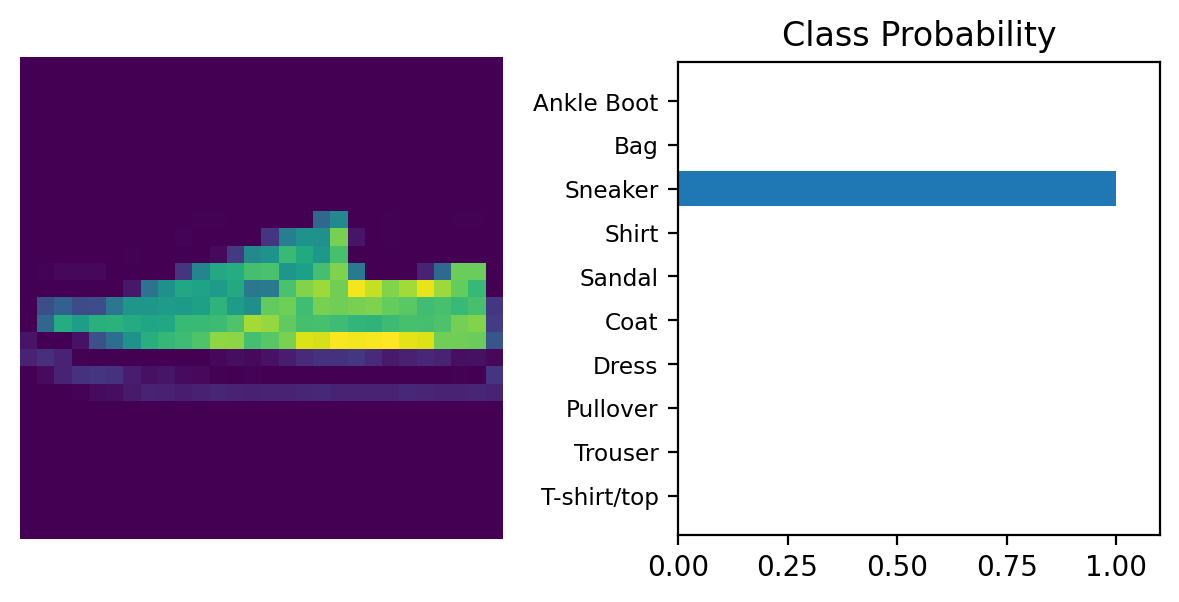

In [23]:

# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')